In [1]:
!pip install gymnasium==0.29.1 pygame matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.2.2
    Uninstalling gymnasium-1.2.2:
      Successfully uninstalled gymnasium-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


In [3]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

In [4]:
env = gym.make("FrozenLake-v1", is_slippery=False)
state, info = env.reset()
print("Initial state:", state)
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)
env.close()

Initial state: 0
Action space: Discrete(4)
Observation space: Discrete(16)


In [12]:
def make_custom_6x6_map(seed=None):
    # p is probability of a safe "F" tile
    # Your assignment wants 20% holes => 80% safe => p = 0.8
    np_random = np.random.RandomState(seed)
    valid = False
    desc = None

    while not valid:
        # Gymnasium generates maps as list of strings
        desc = generate_random_map(size=6, p=0.8, seed=np_random.randint(0, 100000))
        # generate_random_map already guarantees at least one valid path
        valid = True

    return desc

custom_map = make_custom_6x6_map(seed=42)
print(custom_map)

['SFFFFF', 'FFFFFF', 'FFFHFF', 'HFFHFF', 'FFHFFF', 'HFFFFG']


In [6]:
desc = custom_map

env_det = gym.make(
    "FrozenLake-v1",
    desc=desc,
    is_slippery=False
)

env_slip = gym.make(
    "FrozenLake-v1",
    desc=desc,
    is_slippery=True
)

In [8]:
def q_learning_train(env, num_episodes=5000, alpha=0.8, gamma=0.95,
                     epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.999):
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    Q = np.zeros((n_states, n_actions))

    episode_rewards = []

    epsilon = epsilon_start

    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            # epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state, :])

            next_state, reward, terminated, truncated, info = env.step(action)

            done = terminated or truncated

            # Q-learning update
            best_next_action = np.argmax(Q[next_state, :])
            td_target = reward + gamma * Q[next_state, best_next_action]
            td_error = td_target - Q[state, action]
            Q[state, action] += alpha * td_error

            state = next_state
            total_reward += reward

        # decay epsilon after each episode
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        episode_rewards.append(total_reward)

    return Q, np.array(episode_rewards)

In [9]:
Q_det, rewards_det = q_learning_train(
    env_det,
    num_episodes=5000,
    alpha=0.8,
    gamma=0.95,
    epsilon_start=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.999
)

print("Average reward over last 500 episodes (deterministic):",
      rewards_det[-500:].mean())

Average reward over last 500 episodes (deterministic): 0.0


In [10]:
Q_slip, rewards_slip = q_learning_train(
    env_slip,
    num_episodes=5000,
    alpha=0.8,
    gamma=0.95,
    epsilon_start=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.999
)

print("Average reward over last 500 episodes (slippery):",
      rewards_slip[-500:].mean())

Average reward over last 500 episodes (slippery): 0.832


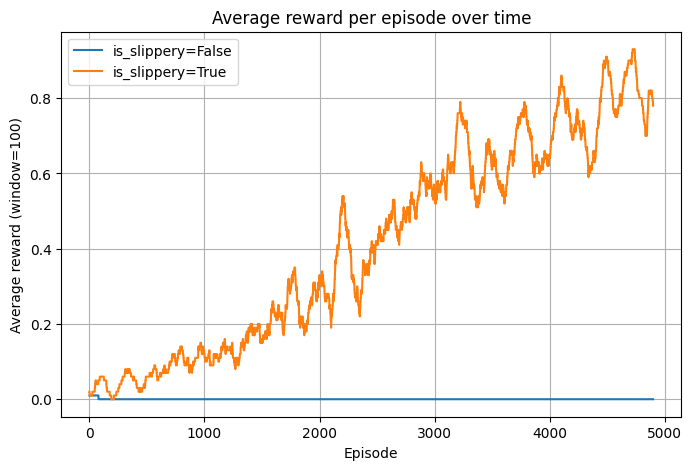

In [11]:
def moving_average(x, window=100):
    return np.convolve(x, np.ones(window)/window, mode='valid')

window = 100
ma_det = moving_average(rewards_det, window)
ma_slip = moving_average(rewards_slip, window)

plt.figure(figsize=(8,5))
plt.plot(ma_det, label="is_slippery=False")
plt.plot(ma_slip, label="is_slippery=True")
plt.xlabel("Episode")
plt.ylabel(f"Average reward (window={window})")
plt.title("Average reward per episode over time")
plt.legend()
plt.grid(True)
plt.show()